##ECE M214A Project: Speaker Region Identification



In this project, we'll train a machine learning algorithm to classify speakers by regional dialect.  We will use speech samples from the Corpus of Regional African American Language (CORAAL - https://oraal.uoregon.edu/coraal) with speakers each belonging to one of five different US cities: 1) Rochester, NY (ROC), 2) Lower East Side, Manhattan, NY (LES), 3) Washington DC (DCB), 4) Princeville, NC (PRV), or 5) Valdosta, GA (VLD).

The project files can be downloaded from [this link](https://ucla.box.com/s/332ewjf1fjmod77c4r2b7c1zq8j1a9pp)

To do this, we will first extract features from the audio files and then train a classifier to predict the city of origin of the utterance's speaker.  The goal is to extract a feature that contains useful information about regional dialect characteristics.

##1. Setting up the data directories and Google Colab

Find the data for this project here: https://drive.google.com/drive/folders/1DRiIxfj5G6VzfHr1ojXxeE1YdLbae5xH?usp=sharing and store a copy in your google drive.  

Make sure that the 'project_data' folder is stored in the top level of your google drive.  Otherwise, you will need to change the corresponding paths in the remainder of the notebook.

Mount your google drive. This will give this notebook read/write access to data stored in your google drive.  You can either do this in the file browser on the left side of this notebook or by running the code snippet below. 

It is recommended that you use your UCLA google account for this project, as it has more storage than a standard google account.

In [ ]:
!pip install spafe
!pip install disvoice

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
root = ''

To run this project on your local system, replace the corresponding file paths to the locations of the project files on your local machine

## 2. Getting familiar with the data


Let's take a moment to understand the data.  The original CORAAL dataset consists of ~85 different speakers, each from one of five cities.  The audio files are names with the convention: DCB_se1_ag1_f_03.  Here, DCB is the city code, se1 denotes the socioeconomic group of the speaker, ag1 denotes the age group of the speaker, f denotes female, and 03 denotes the participant number.  These unique combinations of identifiers mark the speaker.  

The dataset has been preprocessed to only include audio segments greater than 10 seconds in length. there are a number of audio snippets of at least 10sec in length.  Those segments are numbered with the appending tag _seg_number for each segment.

You can also try listening to any segment like this:

In [2]:
from IPython.display import Audio

sr = 44100
Audio(filename= f"./data/train_clean/DCB_se1_ag1_f_03_1_seg_3.wav", rate=sr)
# Audio(filename= "drive/MyDrive/Colab Notebooks/project_data/train_clean/DCB_se1_ag1_f_03_1_seg_3.wav", rate=sr)

The original dataset has also been split into a train and test set. The test set has been further split, with a portion corrupted with the addition of 10dB babble noise:

In [86]:
sr = 44100
Audio(filename= "data/test_noisy/LES_se0_ag3_f_01_1_seg_51.wav", rate=sr)
# Audio(filename= "drive/MyDrive/Colab Notebooks/project_data/test_noisy/LES_se0_ag3_f_01_1_seg_57.wav", rate=sr)

## 3. Feature Extraction

As a baseline, we will be using the average mfcc value over time from the Librosa Python library. Your job will be to choose better features to improve performance on both the clean and noisy data

We first define a pair of functions to create features and labels for our classification model:


In [37]:
import librosa
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # try to use gpu for accelaration
print(device)


cuda


### (1) ComParE


In [21]:
import opensmile
import noisereduce as nr
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors)


#### Try to denoise the noisy test set

In [133]:
from denoise import AudioDeNoise 
test_noisy_files = glob('./data/test_noisy/*.wav')
test_noisy_files.sort() 
test_noisy_feat=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):
    audio,fs = torchaudio.load(wav)
    audio = audio.numpy().reshape(-1)
    audioDenoiser = AudioDeNoise(inputFile=wav)
    file_name = wav.split('/')
    file_name = file_name[-1].split('\\')
    audioDenoiser.deNoise(outputFile=f'./data/test_noisy_denoise/{file_name[-1]}')

  0%|          | 0/347 [00:00<?, ?it/s]Level value of 2 is too high: all coefficients will experience boundary effects.
11it [00:00, 224.62it/s]
10it [00:00, 345.05it/s]00:00<01:23,  4.15it/s]
11it [00:00, 234.03it/s]00:00<01:10,  4.89it/s]
10it [00:00, 196.20it/s]00:00<01:12,  4.72it/s]
11it [00:00, 289.66it/s]00:00<01:14,  4.62it/s]
11it [00:00, 333.11it/s]00:01<01:07,  5.05it/s]
11it [00:00, 423.31it/s]00:01<01:05,  5.22it/s]
10it [00:00, 238.11it/s]
10it [00:00, 256.55it/s]00:01<01:00,  5.64it/s]
11it [00:00, 203.83it/s]00:01<01:00,  5.57it/s]
  3%|▎         | 10/347 [00:01<01:05,  5.15it/s]invalid value encountered in divide
11it [00:00, 439.80it/s]
11it [00:00, 127.98it/s][00:02<01:05,  5.11it/s]
11it [00:00, 314.47it/s][00:02<01:16,  4.38it/s]
11it [00:00, 234.19it/s][00:02<01:10,  4.72it/s]
11it [00:00, 239.28it/s][00:02<01:06,  4.99it/s]
11it [00:00, 169.33it/s][00:02<01:01,  5.40it/s]
11it [00:00, 256.00it/s][00:03<01:00,  5.51it/s]
11it [00:00, 314.75it/s][00:03<00:57,  5.71

In [134]:
def extract_feature(audio_file, denoise=True):
  '''
  Function to extract ComParE16 features from a single audio file given its path
  '''
  audio,fs = torchaudio.load(audio_file)
  audio = audio.numpy().reshape(-1)
  
  # ComParE
  if denoise:
    audio = nr.reduce_noise(y=audio, sr=fs)  # denoise the audio, but is not helpful for classification
  feat_out = smile.process_signal(audio, fs)
  feat_out = np.mean(feat_out, axis=0)

  return feat_out

def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

### (2) MFCC

### (2.1) MFCC (torchaudio)

In [61]:
transform = torchaudio.transforms.MFCC(sample_rate=44100, n_mfcc=13).to(device)  # use gpu to accelerate
def extract_feature(audio_file):

  '''
  Function to extract MFCC features from a single audio file given its path
  torchaudio version
  '''

  audio, fs = torchaudio.load(audio_file)
  audio = audio.reshape(-1).to(device)
  mfccs = transform(audio)
  feat_out = torch.mean(mfccs,dim=1)
  return feat_out

def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

### (2.2)MFCC (librosa)

In [58]:
def extract_feature(audio_file, n_mfcc=13):

  '''
  Function to extract MFCC features from a single audio file given its path
  '''

  audio,fs = torchaudio.load(audio_file)
  audio = audio.numpy().reshape(-1)
  if fs != 44100:
    print('no!')
  # replace the following features with your own
  mfccs = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=n_mfcc)

  feat_out = np.mean(mfccs,axis=1)
  
  return feat_out

def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

### (3) LFCC

In [15]:
transform = torchaudio.transforms.LFCC(sample_rate=44100).to(device)
def extract_feature(audio_file):

  '''
  Function to extract LFCC features from a single audio file given its path

  '''

  audio, fs = torchaudio.load(audio_file)
  audio = audio.reshape(-1).to(device)
  lfccs = transform(audio)
  feat_out = torch.mean(lfccs,dim=1)

  return feat_out
def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

### (4) LPC

In [28]:
def extract_feature(audio_file):

  '''
  Function to extract LPC features from a single audio file given its path
  '''

  audio, fs = torchaudio.load(audio_file)
  audio = audio.numpy().reshape(-1)
  
  feat_out = librosa.lpc(y=audio, order=12)

  return feat_out

def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

### (5) prosody, phonation, mfcc (orignal, 1st derivative, 2nd derivative), pncc, lpc

In [ ]:
import librosa
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm
from math import floor
framelen = 40*44100

import spafe
from spafe.features.pncc import pncc

import disvoice
from disvoice import Phonation
from disvoice import Prosody
prosody = Prosody()
phonation = Phonation()

def extract_feature(audio_file, n_mfcc=13, n_lpc=48):

  '''
  Function to extract features from a single audio file given its path
  Modify this function to extract your own custom features
  '''

  audio,fs = torchaudio.load(audio_file)
  audio = audio.numpy().reshape(-1)

  ## replace the following features with your own

  mfcc_ = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=13) # x-axis #frame, y-axis #quefrency, value as cepstrum
  mfcc_frameavg = np.mean(mfcc_,axis=1)
  mfcc_delta = librosa.feature.delta(mfcc_frameavg)
  mfcc_delta2 = librosa.feature.delta(mfcc_frameavg, order=2)
  feat_mfcc = np.concatenate((mfcc_frameavg, mfcc_delta, mfcc_delta2), axis=0)


  pncc_  = pncc(audio, fs=fs, num_ceps=13)  
  pncc_frameavg = np.mean(pncc_,axis=0)
  feat_pncc = pncc_frameavg


  nframes_lpc = floor(len(audio)/framelen) + 1
  lpc_mat = np.zeros((nframes_lpc, n_lpc+1))

  for n in range(nframes_lpc):
    start_index = n*framelen
    end_index = start_index + framelen
    
    if n == nframes_lpc:
        end_index = len(audio)    
    
    lpc_coeff = librosa.lpc(y=audio[start_index:end_index], order=n_lpc)
    lpc_mat[n] = lpc_coeff

  feat_lpc = np.mean(lpc_mat,axis=0)


  feat_prosody = prosody.extract_features_file(audio_file, static=True, plots=False, fmt="npy")


  phonation_ = phonation.extract_features_file(audio_file, static=False, plots=False, fmt="npy")
  feat_phonation = np.mean(phonation_,axis=0)


  feat_out = np.concatenate((feat_mfcc, feat_lpc, feat_pncc, feat_prosody, feat_phonation), axis=0)

  return feat_out


## Extract features

Let us now call these functions to extract the features and labels from the train_clean directory

In [62]:
#First we obtain the list of all files in the train_clean directory
# train_files = glob('drive/MyDrive/project_data/train_clean/*.wav')
train_files = glob('./data/train_clean/*.wav')

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort() 

train_feat=[]
train_label=[]
count = 0
for wav in tqdm(train_files):
  train_feat.append(extract_feature(wav))
  train_label.append(get_label(wav))
  count += 1

100%|██████████| 4372/4372 [03:43<00:00, 19.60it/s]


Store the data to save the time. Just need for one time.

In [66]:
feature_name = 'mfcc'

train_feat = np.stack(train_feat)  # if use the torch version, torch.stack()
train_label = np.stack(train_label)
print(train_feat.shape)
print(train_label.shape)
np.save(f'./results/train_clean/feature_{feature_name}.npy', train_feat)
# if we use gpu and torch to process the data, following codes are needed 
# np.save(f'./results/train_clean/feature_{feature_name}.npy', train_feat.cpu().numpy())
np.save(f'./results/train_clean/label_{feature_name}.npy', train_label)

torch.Size([4372, 39])
(4372,)


In [67]:
#Now we obtain the list of all files in the test_clean directory
# test_clean_files = glob('drive/MyDrive/Colab Notebooks/project_data/test_clean/*.wav')
test_clean_files = glob('./data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort() 

test_clean_feat=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat.append(extract_feature(wav))
  test_clean_label.append(get_label(wav))

100%|██████████| 447/447 [00:21<00:00, 20.84it/s]


In [68]:
test_clean_feat = np.stack(test_clean_feat)  # if use the torch version, torch.stack()
test_clean_label = np.stack(test_clean_label)
print(test_clean_feat.shape)
print(test_clean_label.shape)
np.save(f'./results/test_clean/feature_{feature_name}.npy', test_clean_feat)
# np.save(f'./results/test_clean/feature_{feature_name}.npy', test_clean_feat.cpu().numpy())
np.save(f'./results/test_clean/label_{feature_name}.npy', test_clean_label)

torch.Size([447, 39])
(447,)


In [69]:
#Finally we obtain the list of all files in the test_noisy directory
# test_noisy_files = glob('drive/MyDrive/project_data/test_noisy/*.wav')
test_noisy_files = glob('./data/test_noisy_denoise/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort() 

test_noisy_feat=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat.append(extract_feature(wav))
  test_noisy_label.append(get_label(wav))

100%|██████████| 347/347 [00:28<00:00, 11.97it/s]


In [70]:
test_noisy_feat = np.stack(test_noisy_feat)  # if use the torch version, torch.stack()
test_noisy_label = np.stack(test_noisy_label)
print(test_noisy_feat.shape)
print(test_noisy_label.shape)

np.save(f'./results/test_noisy/feature_{feature_name}.npy', test_noisy_feat)
# np.save(f'./results/test_noisy/feature_{feature_name}.npy', test_noisy_feat.cpu().numpy())
np.save(f'./results/test_noisy/label_{feature_name}.npy', test_noisy_label)

torch.Size([347, 39])
(347,)


## 4. Model Training and Predictions

Now we'll train the backend system to predict the regions from the input features.  We'll use an xgboosted decision tree for this.  An advantage of this model is that we can also parse the decision tree and measure the impact of different features in the end result for explainability

In [ ]:
# #Install shap library
# !pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 35.6 MB/s eta 0:00:00


In [ ]:
import xgboost
import numpy as np
import shap
import pandas as pd

#Format input data

#Edit this variable to create a list that contains your feature names
feat_names=[f'{feature_name}_' +str(n) for n in range(len(train_feat[0]))]

train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
# train_feat_df = pd.DataFrame(data=torch.stack(train_feat).cpu().numpy(), columns=feat_names)

y_train=np.stack(train_label)


test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
# test_clean_feat_df = pd.DataFrame(data=torch.stack(test_clean_feat).cpu().numpy(), columns=feat_names)

y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
# test_noisy_feat_df = pd.DataFrame(data=torch.stack(test_noisy_feat).cpu().numpy(), columns=feat_names)

y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.  


model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)


print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


To save a dataframe of features, uncomment and run the following block of code

### MFCC + LPC + PNCC + Phonation 

In [ ]:
feat_names_mfcc_avg = ['mfcc_' +str(n) for n in range(13)]
feat_names_mfcc_delta = ['mfcc_delta_' +str(n) for n in range(13)]
feat_names_mfcc_delta2 = ['mfcc_delta2_' +str(n) for n in range(13)]
feat_names_mfcc = feat_names_mfcc_avg + feat_names_mfcc_delta + feat_names_mfcc_delta2
feat_names_lpc = ['LPC' +str(n) for n in range(48)]
feat_names_pncc = ['pncc_' +str(n) for n in range(13)]
feat_names_prosody = ['mfcc_' +str(n) for n in range(103)]
feat_names_phonation = ['phonation_' +str(n) for n in range(7)]
feat_names = feat_names_mfcc + feat_names_lpc + feat_names_pncc + feat_names_prosody + feat_names_phonation

train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
model = xgboost.XGBClassifier()
model.fit(train_feat_df, y_train)


print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))

### ComParE16 features

In [86]:
import xgboost
import numpy as np
import shap
import pandas as pd

# for some features group, we'd like to select some of them
file_name = 'ComparE_2016_low'
train_feat = np.load(f'./results/train_clean/feature_{file_name}.npy')
test_clean_feat = np.load(f'./results/test_clean/feature_{file_name}.npy')
test_noisy_feat = np.load(f'./results/test_noisy/feature_{file_name}.npy')


# we found the order of the features matters. so we shuffle the features order to get the best combinations

feat_name = file_name
feat_names=[feat_name +str(n) for n in range(train_feat.shape[1])]
# feat_names = [x.replace('[', '').replace(']','') for x in smile.feature_names]

y_train = np.load('./results/train_clean/label.npy')

# delete some features to see the influence of the imbalance data set
# idx = np.where(y_train==2)[0]
# idx = idx[:2000]
# train_feat = np.delete(train_feat, idx, axis=0)
# y_train = np.delete(y_train, idx)

train_feat_df = pd.DataFrame(data=train_feat, columns=feat_names)


test_clean_feat_df = pd.DataFrame(data=test_clean_feat, columns=feat_names)
y_test_clean = np.load('./results/test_clean/label.npy')


test_noisy_feat_df = pd.DataFrame(data=test_noisy_feat, columns=feat_names)
y_test_noisy = np.load('./results/test_noisy/label.npy')

model = xgboost.XGBClassifier()
model.fit(train_feat_df, y_train)


print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


Train Clean Acc = 1.0
Test Clean Acc = 0.9261744966442953
Test Noisy Acc = 0.654178674351585


### Combined features and get the best model

In [87]:
import xgboost
import numpy as np
import shap
import pandas as pd

# for some features group, we'd like to select some of them
# file_name = 'ComparE_2016_low'
# train_feat = np.load(f'./results/train_clean/feature_{file_name}.npy')
# test_clean_feat = np.load(f'./results/test_clean/feature_{file_name}.npy')
# test_noisy_feat = np.load(f'./results/test_noisy/feature_{file_name}.npy')
# feature_list = [51, 52, 1,58, 45,8, 54, 35, 6, 62, 46, 56] #[52, 1, 51, 45, 6,35, 44, 42, 53, 11, 36, 35, 12]
# # train_feat = np.stack([train_feat[:, i] for i in feature_list], 1)
# # test_clean_feat = np.stack([test_clean_feat[:, i] for i in feature_list], 1)
# # test_noisy_feat = np.stack([test_noisy_feat[:, i] for i in feature_list], 1)

# we found the below features can achieve highest accuracy, so we want to concat them
feature_name_list = ['LibrosaMFCC' ,'mfcc', 'PNCC','LPC_40s_window',  'Prosody', 'Phonation','ComparE_2016_low',]
for idx, feature in enumerate(feature_name_list):
    if idx == 0:
        train_feat = np.load(f'./results/train_clean/feature_{feature}.npy')
        test_clean_feat = np.load(f'./results/test_clean/feature_{feature}.npy')
        test_noisy_feat = np.load(f'./results/test_noisy/feature_{feature}.npy')
    else:
        train_feat2 = np.load(f'./results/train_clean/feature_{feature}.npy')
        test_clean_feat2 = np.load(f'./results/test_clean/feature_{feature}.npy')
        test_noisy_feat2 = np.load(f'./results/test_noisy/feature_{feature}.npy')

        train_feat = np.concatenate((train_feat2, train_feat), axis=1)
        test_clean_feat = np.concatenate((test_clean_feat2, test_clean_feat), axis=1)
        test_noisy_feat = np.concatenate((test_noisy_feat2, test_noisy_feat), axis=1)

# we found the order of the features matters. so we shuffle the features order to get the best combinations
s_p =[]
np.random.seed()
for i in range(40):
    p = np.random.permutation(train_feat.shape[1])
    train_feat = train_feat[:, p]
    test_clean_feat = test_clean_feat[:, p]
    test_noisy_feat = test_noisy_feat[:, p]

    feat_names=['feature' +str(n) for n in range(train_feat.shape[1])]
    
    train_feat_df = pd.DataFrame(data=train_feat, columns=feat_names)
    y_train = np.load('./results/train_clean/label.npy')



    test_clean_feat_df = pd.DataFrame(data=test_clean_feat, columns=feat_names)
    y_test_clean = np.load('./results/test_clean/label.npy')

    test_noisy_feat_df = pd.DataFrame(data=test_noisy_feat, columns=feat_names)
    y_test_noisy = np.load('./results/test_noisy/label.npy')

    model = xgboost.XGBClassifier()
    model.fit(train_feat_df, y_train)
  
    print(f'-----------{i}-------------')
    test_clean_acc = np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean)
    test_noisy_acc = np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy)
    if test_clean_acc >= 0.912751677852349 and test_noisy_acc >= 0.729106628242075:   # empirical results achieved by trials manually
        print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

        print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

        print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))
        s_p.append(p)


-----------0-------------


### Best model

In [75]:
import xgboost
import numpy as np
import shap
import pandas as pd

feature_name_list = ['LibrosaMFCC' ,'mfcc', 'PNCC','LPC_40s_window',  'Prosody', 'Phonation','ComparE_2016_low']
for idx, feature in enumerate(feature_name_list):
    if idx == 0:
        train_feat = np.load(f'./results/train_clean/feature_{feature}.npy')
        test_clean_feat = np.load(f'./results/test_clean/feature_{feature}.npy')
        test_noisy_feat = np.load(f'./results/test_noisy/feature_{feature}.npy')
    else:
        train_feat2 = np.load(f'./results/train_clean/feature_{feature}.npy')
        test_clean_feat2 = np.load(f'./results/test_clean/feature_{feature}.npy')
        test_noisy_feat2 = np.load(f'./results/test_noisy/feature_{feature}.npy')

        train_feat = np.concatenate((train_feat2, train_feat), axis=1)
        test_clean_feat = np.concatenate((test_clean_feat2, test_clean_feat), axis=1)
        test_noisy_feat = np.concatenate((test_noisy_feat2, test_noisy_feat), axis=1)

order = np.load('./results/best_order.npy')

train_feat = train_feat[:, order]
test_clean_feat = test_clean_feat[:, order]
test_noisy_feat = test_noisy_feat[:, order]

feature_name_lists = ['librosaMFCC' ,'torchaudioMFCC', 'PNCC','LPC_40s_window',  'Prosody', 'Phonation','ComparE16']
feat_names = []
N = [39, 13, 13, 49, 103, 7, 65]
for i, name in enumerate(feature_name_lists):
    if name == 'ComparE16':
        temp = [x.replace('[', '').replace(']','') for x in smile.feature_names]
    else:
        temp = [name +str(n) for n in range(N[i])]
    feat_names.extend(temp)
feat_names = np.array(feat_names)[order]
# feat_names=['feature' +str(n) for n in range(train_feat.shape[1])]

train_feat_df = pd.DataFrame(data=train_feat, columns=feat_names)
y_train = np.load('./results/train_clean/label.npy')



test_clean_feat_df = pd.DataFrame(data=test_clean_feat, columns=feat_names)
y_test_clean = np.load('./results/test_clean/label.npy')

test_noisy_feat_df = pd.DataFrame(data=test_noisy_feat, columns=feat_names)
y_test_noisy = np.load('./results/test_noisy/label.npy')

model = xgboost.XGBClassifier()
model.fit(train_feat_df, y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


Train Clean Acc = 1.0
Test Clean Acc = 0.912751677852349
Test Noisy Acc = 0.729106628242075


### Include some noisy samples into training set

In [36]:
import xgboost
import numpy as np
import shap
import pandas as pd

file_name = 'mfcc'
train_feat = np.load(f'./results/train_clean/feature_{file_name}.npy')
test_clean_feat = np.load(f'./results/test_clean/feature_{file_name}.npy')
test_noisy_feat = np.load(f'./results/test_noisy/feature_{file_name}.npy')
feat_name = file_name
feat_names=[feat_name +str(n) for n in range(train_feat.shape[1])]

y_train = np.load('./results/train_clean/label.npy')
train_feat_df = pd.DataFrame(data=train_feat, columns=feat_names)

test_clean_feat_df = pd.DataFrame(data=test_clean_feat, columns=feat_names)
y_test_clean = np.load('./results/test_clean/label.npy')

test_noisy_feat_df = pd.DataFrame(data=test_noisy_feat, columns=feat_names)
y_test_noisy = np.load('./results/test_noisy/label.npy')

n_step = 20
step_size = 10
iterations = 30
train_acc = np.zeros((n_step, iterations))
test_clean_acc = np.zeros((n_step, iterations))
test_noisy_acc = np.zeros((n_step, iterations))
for i in range(n_step):
    ratio  = step_size * (i + 1)
    print('ratio:', ratio)
    for k in range(iterations):
        model = xgboost.XGBClassifier()
        idx = np.random.choice(y_test_noisy.shape[0],  ratio)
        model.fit(np.concatenate([train_feat, test_noisy_feat[idx]]),np.concatenate([y_train, y_test_noisy[idx]]))
        test_noisy_feat_2 = np.delete(test_noisy_feat, idx, axis=0)
        y_test_noisy_2 = np.delete(y_test_noisy, idx, axis=0)
        test_noisy_feat_df = pd.DataFrame(data=test_noisy_feat_2, columns=feat_names)
        train_acc[i, k] = np.sum(y_train==model.predict(train_feat_df))/len(y_train)
        test_clean_acc[i, k] = np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean)
        test_noisy_acc[i, k] = np.sum(y_test_noisy_2==model.predict(test_noisy_feat_2))/len(y_test_noisy_2)

    print("Train Clean Acc =", np.mean(train_acc[i]))
    print("Test Clean Acc =", np.mean(test_clean_acc[i]))
    print("Test Noisy Acc =", np.mean(test_noisy_acc[i]))


ratio: 10
Train Clean Acc = 1.0
Test Clean Acc = 0.6320656226696496
Test Noisy Acc = 0.8621954360027859
ratio: 20
Train Clean Acc = 1.0
Test Clean Acc = 0.6340790454884415
Test Noisy Acc = 0.9059113642187705
ratio: 30
Train Clean Acc = 1.0
Test Clean Acc = 0.6325876211782252
Test Noisy Acc = 0.9312827556990967
ratio: 40
Train Clean Acc = 1.0
Test Clean Acc = 0.6339299030574197
Test Noisy Acc = 0.9471789398328493
ratio: 50
Train Clean Acc = 1.0
Test Clean Acc = 0.6322147651006712
Test Noisy Acc = 0.9555299012593662
ratio: 60
Train Clean Acc = 1.0
Test Clean Acc = 0.6321401938851604
Test Noisy Acc = 0.9636854355185903
ratio: 70
Train Clean Acc = 1.0
Test Clean Acc = 0.631021625652498
Test Noisy Acc = 0.9689826023517936
ratio: 80
Train Clean Acc = 1.0
Test Clean Acc = 0.6316181953765848
Test Noisy Acc = 0.9747446623268075
ratio: 90
Train Clean Acc = 1.0
Test Clean Acc = 0.6309470544369874
Test Noisy Acc = 0.9725896729000625
ratio: 100
Train Clean Acc = 1.0
Test Clean Acc = 0.6313944817300

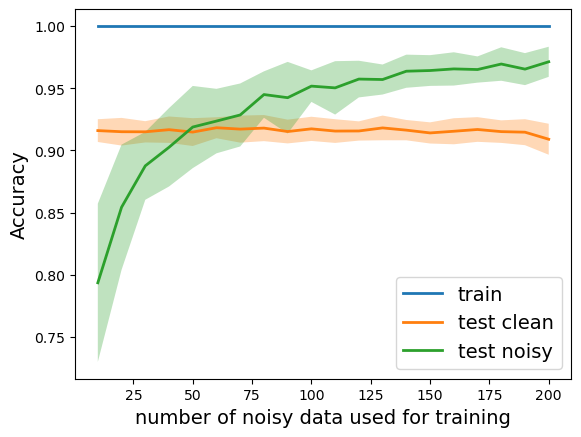

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt 

fig, ax= plt.subplots()

train_mean = np.mean(train_acc, axis=1)
train_std = np.std(train_acc, axis=1)
x = np.arange(n_step) * step_size + step_size
lower_bound = train_mean - train_std
upper_bound = train_mean + train_std
h1 = plt.plot(x, train_mean, linewidth=2, label='train')
plt.fill_between(x, lower_bound, upper_bound, alpha=.3)

test_clean_mean = np.mean(test_clean_acc, axis=1)
test_clean_std = np.std(test_clean_acc, axis=1)
lower_bound = test_clean_mean - test_clean_std
upper_bound = test_clean_mean + test_clean_std
h2 = plt.plot(x, test_clean_mean, linewidth=2, label='test clean')
plt.fill_between(x, lower_bound, upper_bound, alpha=.3)

test_noisy_mean = np.mean(test_noisy_acc, axis=1)
test_noisy_std = np.std(test_noisy_acc, axis=1)
lower_bound = test_noisy_mean - test_noisy_std
upper_bound = test_noisy_mean + test_noisy_std
h3 = plt.plot(x, test_noisy_mean, linewidth=2, label='test noisy')
plt.fill_between(x, lower_bound, upper_bound, alpha=.3)

plt.xlabel('number of noisy data used for training', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc=4, fontsize=14)
plt.savefig("results/figure/da.png",dpi=600, bbox_inches='tight')

### Save dataframe

To Load a preexisting dataframe of features (saved from a previous notebook), run the following cell and then train the model

In [ ]:
# train_feat_df = pd.read_csv('drive/MyDrive/myfeat_train.csv')
# test_clean_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_clean.csv')
# test_noisy_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_noisy.csv')

The following cells are to extract features from MATLAB. Ensure that you've run the baseline once before running the cells

Saving list of train_clean, test_clean and test_noisy files 

In [ ]:
# Note: we save the list of files to ensure the labels match the utterances
# You can omit this step if you plan on extracting the labels in MATLAB
# But will need to rewrite other parts of the notebook

# with open('train_files.txt', 'w') as f:
#     for line in train_files:
#         f.write(f"{line}\n")

# with open('test_clean_files.txt', 'w') as f:
#     for line in test_clean_files:
#         f.write(f"{line}\n")

# with open('test_noisy_files.txt', 'w') as f:
#     for line in test_noisy_files:
#         f.write(f"{line}\n")

After extracting features using wrapper.m, run the following cell to retrieve a dataframe containing the features

In [ ]:
# train_feat_df = pd.read_csv('drive/MyDrive/myfeat_train.csv')
# test_clean_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_clean.csv')
# test_noisy_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_noisy.csv')

## 5. Interpreting Results and Explainability

To see the impact different features have on the model, we create a plot of the feature importances. The features are listed top to bottom in order of how important they were to the decision.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


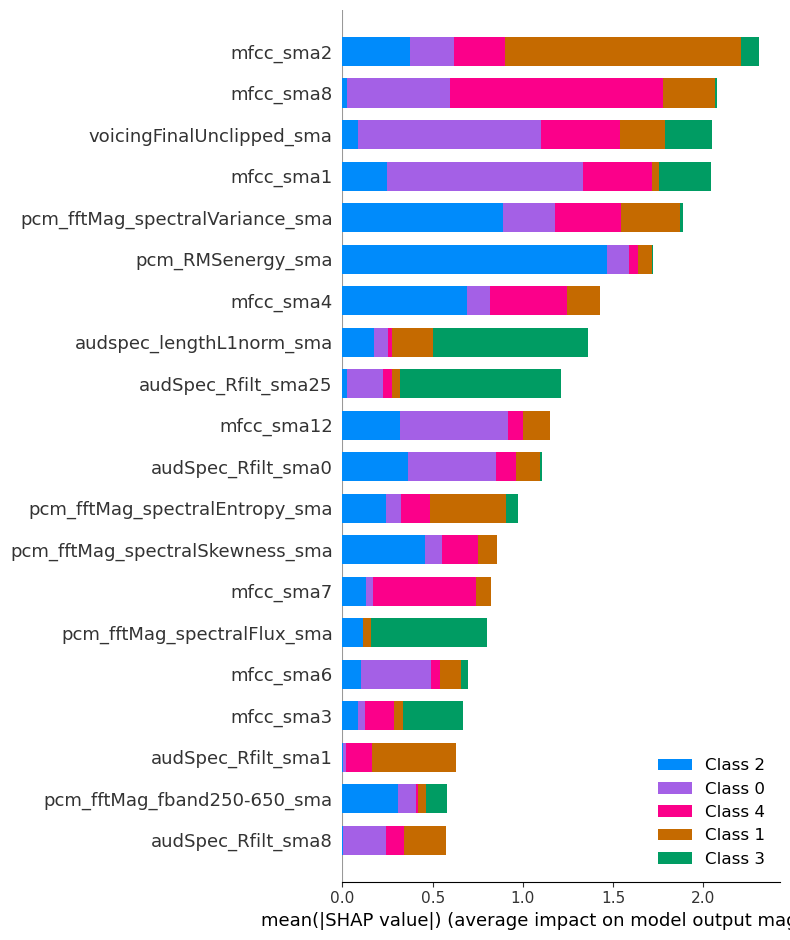

In [35]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_feat_df)
fig = shap.summary_plot(shap_values, train_feat_df, show=False)
plt.savefig("results/figure/ComParE16.png",dpi=600, bbox_inches='tight')

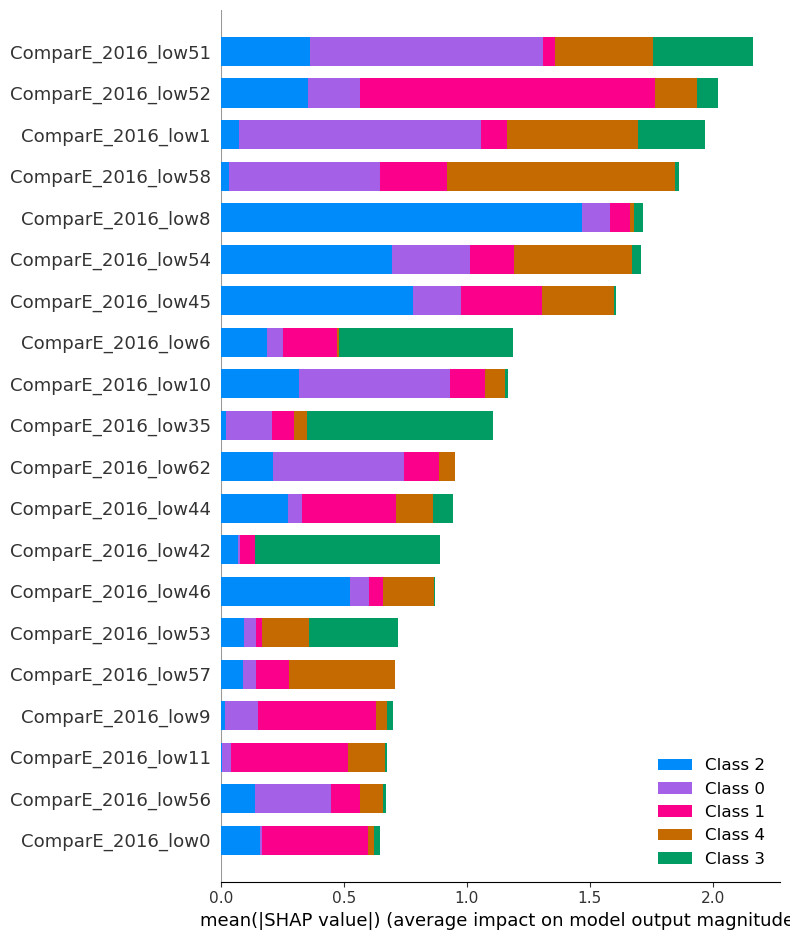

In [279]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_clean_feat_df)
shap.summary_plot(shap_values, test_clean_feat_df, show=True)


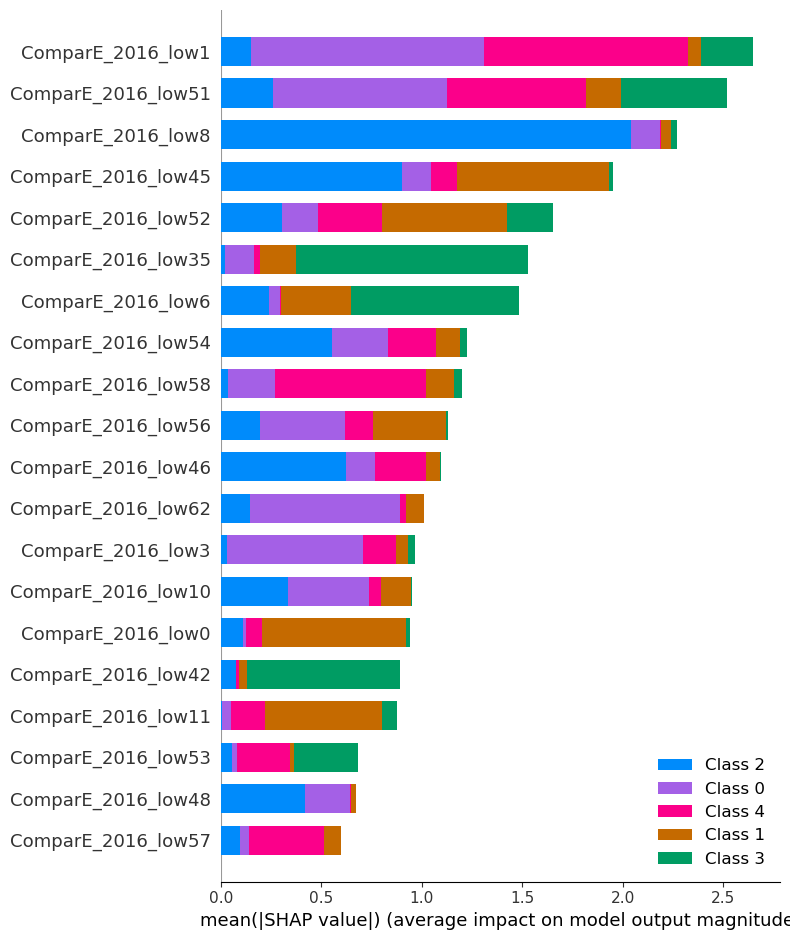

In [280]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_noisy_feat_df)
shap.summary_plot(shap_values, test_noisy_feat_df, show=True)

And we can see a confusion matrix of the mispredictions

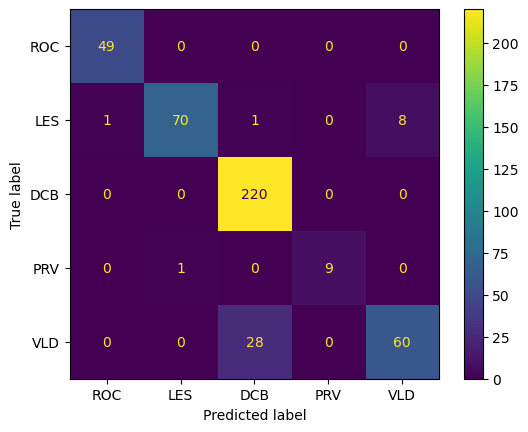

In [76]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
# plt.show()
# plt.savefig("results/figure/ComparE16_clean.png",dpi=300, bbox_inches='tight')

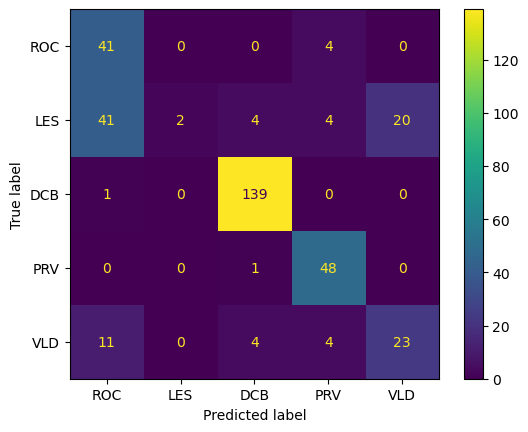

In [78]:
confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
# plt.show()
# plt.savefig("results/figure/ComparE16_noisy.png",dpi=300, bbox_inches='tight')

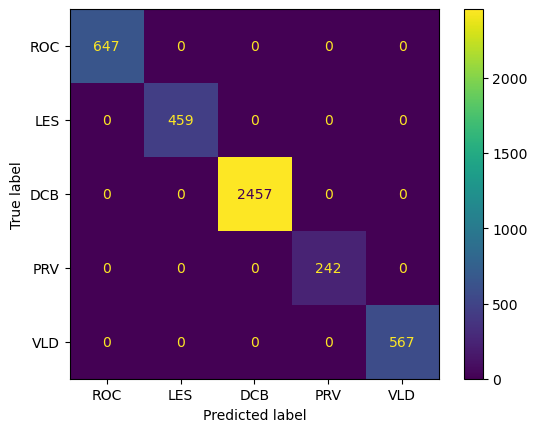

In [77]:
confusion_matrix_train = metrics.confusion_matrix(y_train, model.predict(train_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()
